In [1]:
#Import required libraries

from collections import Counter 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import swifter #allow multiprocessor .apply
%matplotlib inline
import seaborn as sns
import calendar
import sys
import logging
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import copy

from sklearn.exceptions import DataConversionWarning
from sklearn_pandas import DataFrameMapper #https://github.com/scikit-learn-contrib/sklearn-pandas
from sklearn.preprocessing import LabelEncoder, Imputer, StandardScaler
from pandas.api.types import is_string_dtype, is_numeric_dtype
import warnings


In [2]:
#Read our Cleaned Data:
cleaned_data = pd.read_feather('../data/races.cleaned.feather')

/home/bewo/anaconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


In [4]:
cleaned_data.columns

Index(['id', 'track_id', 'challenger', 'opponent', 'money', 'winner', 'status',
       'weather', 'cleaned_race_created', 'cleaned_race_driven',
       'cleaned_fuel_consumption', 'forecast_sunny', 'forecast_rainy',
       'forecast_thundery', 'forecast_snowy', 'forecasted_wheater',
       'forecasted_confidence'],
      dtype='object')

# Feature Engineering

We derive the following features, that are realistic to derive given a new upcoming race:

- Hour of Day for Race driven
- Month and Year for Race driven
- Day of the week for Race driven
- How many days in advance was the race created (i.e. how much preparation did the drivers had?)

In [5]:
finished_races = cleaned_data['status'] == 'finished'
feature_data = cleaned_data.loc[finished_races,['track_id','challenger','opponent','money','forecast_sunny','forecast_rainy','forecast_thundery','forecast_snowy','cleaned_fuel_consumption']]
feature_data['hour'] = cleaned_data.loc[finished_races,'cleaned_race_driven'].apply(lambda x: x.hour)
feature_data['month'] = cleaned_data.loc[finished_races,'cleaned_race_driven'].apply(lambda x: x.month)
feature_data['year'] = cleaned_data.loc[finished_races,'cleaned_race_driven'].apply(lambda x: x.year)
feature_data['day_of_week'] = cleaned_data.loc[finished_races,'cleaned_race_driven'].apply(lambda x: x.weekday())
feature_data['days_known_ahead'] = cleaned_data.loc[finished_races,'cleaned_race_driven'].sub(cleaned_data.loc[finished_races,'cleaned_race_created'], axis=0) / np.timedelta64(1, 'D')

In [6]:
fuel_consumption_pred = feature_data

In [7]:
for i in ['challenger','opponent','day_of_week','month','hour','year']:
    fuel_consumption_pred[i] = fuel_consumption_pred[i].astype('category')
fuel_consumption_pred.dtypes

track_id                    category
challenger                  category
opponent                    category
money                          int64
forecast_sunny                 int64
forecast_rainy                 int64
forecast_thundery              int64
forecast_snowy                 int64
cleaned_fuel_consumption     float64
hour                        category
month                       category
year                        category
day_of_week                 category
days_known_ahead             float64
dtype: object

Let's define two sets of features we are going to incorporate into our model.
We split the input variables into categorical and continous variables.


In [8]:
categorical_to_use = set(list(fuel_consumption_pred.select_dtypes(include='category').columns)) #categorical variables
continuous_to_use = set(list(fuel_consumption_pred.select_dtypes(exclude='category').columns)) # numerical variables

for v in categorical_to_use:
    #Rewrite categorical values to Ints e.g. (maennlich = 0, weiblich =1, etc.)
    fuel_consumption_pred[v] = fuel_consumption_pred[v].astype('category').cat.as_ordered() 
    #merged[v] = merged[v].cat.codes

continuous_to_use.remove('cleaned_fuel_consumption')

Our Neural Net will have embeddings for categorical values.

See also: 
  - http://www.fast.ai/2018/04/29/categorical-embeddings/
  - https://towardsdatascience.com/deep-learning-4-embedding-layers-f9a02d55ac12
  - https://en.wikipedia.org/wiki/Word_embedding

The following will compute the size of the embeddings (Note we cap it at 50 and at least use it by count//2 embedding colums.

In [9]:
cat_sz = [(c, len(fuel_consumption_pred[c].cat.categories)+1) for c in categorical_to_use]
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]
for v in categorical_to_use:
    #merged[v] = merged[v].astype('category').cat.as_ordered()
    fuel_consumption_pred[v] = fuel_consumption_pred[v].cat.codes
display(emb_szs)

[(13, 7), (13, 7), (8, 4), (7, 4), (25, 13), (5091, 50), (3636, 50)]

Now we are going to normalize the continous input data using the StandardScaler

In [10]:
#Normalize Data Inputs for neural net using StandardScaler
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
map_f = [([n],StandardScaler()) for n in fuel_consumption_pred.columns if n in continuous_to_use]
mapper = DataFrameMapper(map_f).fit(fuel_consumption_pred)
fuel_consumption_pred[mapper.transformed_names_] = mapper.transform(fuel_consumption_pred)

Next, we prepare the dataset for cross validation, i.e. we split it into training set and validation set.

In [11]:
from sklearn.cross_validation import train_test_split

X_all = fuel_consumption_pred.drop(['cleaned_fuel_consumption'],1)
y_all = fuel_consumption_pred['cleaned_fuel_consumption']

# Shuffle and split the dataset into training and testing set.
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, 
                                                    test_size = 0.25,
                                                    random_state = 2)


/home/bewo/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In the following we will define a helper class to hold our dataset, which helps us handle different datasets later.

In [12]:
# A class to hold our Datasets
class TabularDataset(Dataset):
  def __init__(self, xdata, ydata, cat_cols=None):

    self.n = xdata.shape[0]
    self.y = torch.tensor(ydata.astype(np.double).values) #our target classification vector
        
    self.cat_cols = cat_cols if cat_cols else []
    self.cont_cols = [col for col in xdata.columns
                      if col not in self.cat_cols]

    if self.cont_cols:
      self.cont_X = xdata[self.cont_cols].astype(np.float32).values
    else:
      self.cont_X = np.zeros((self.n, 1))

    if self.cat_cols:
      self.cat_X = xdata[cat_cols].astype(np.int64).values
    else:
      self.cat_X =  np.zeros((self.n, 1))

  def __len__(self):
    return self.n

  def __getitem__(self, idx):
    return [self.y[idx], self.cont_X[idx], self.cat_X[idx]]

In [13]:
training_dataset = TabularDataset( X_train, y_train , cat_cols=list(categorical_to_use))
validation_dataset = TabularDataset( X_test, y_test, cat_cols=list(categorical_to_use))

Now, we will define a class that defines the architecture of our feedforward neural net.

In [14]:
# A class containing the architecture of our neural net
# -> Continuous Values -\
#                        -> Linear Layer - - - - -\
#                                                  \
# Categorical Values -> Embedding Layer -> Dropout ->  (Linear Layer -> ReLU -> BatchNorm -> Dropout) -> ReLu-> SoftMax 
class FeedForwardNN(nn.Module):

  def __init__(self, emb_dims, no_of_cont, lin_layer_sizes,
               output_dim, emb_dropout, lin_layer_dropouts):

    super().__init__()

    # Embedding layers
    self.emb_layers = nn.ModuleList([nn.Embedding(x, y)
                                     for x, y in emb_dims])
    
    no_of_embs = sum([y for x, y in emb_dims])
    self.no_of_embs = no_of_embs
    self.no_of_cont = no_of_cont

    # Linear Layers
    first_lin_layer = nn.Linear(self.no_of_embs + self.no_of_cont,
                                lin_layer_sizes[0])
    
    self.lin_layers =\
     nn.ModuleList([first_lin_layer] +\
          [nn.Linear(lin_layer_sizes[i], lin_layer_sizes[i + 1])
           for i in range(len(lin_layer_sizes) - 1)])
    
    # Output Layer
    self.output_layer = nn.Linear(lin_layer_sizes[-1],
                                      output_dim)

    # Batch Norm Layers
    self.first_bn_layer = nn.BatchNorm1d(self.no_of_cont)
    self.bn_layers = nn.ModuleList([nn.BatchNorm1d(size)
                                    for size in lin_layer_sizes])

    # Dropout Layers
    self.emb_dropout_layer = nn.Dropout(emb_dropout)
    self.dropout_layers = nn.ModuleList([nn.Dropout(size)
                                  for size in lin_layer_dropouts])

  def forward(self, cont_data, cat_data):

    if self.no_of_embs != 0:
      x = [emb_layer(cat_data[:, i])
           for i,emb_layer in enumerate(self.emb_layers)]
      x = torch.cat(x, 1)
      x = self.emb_dropout_layer(x)

    if self.no_of_cont != 0:
      normalized_cont_data = self.first_bn_layer(cont_data)

      if self.no_of_embs != 0:
        x = torch.cat([x, normalized_cont_data], 1) 
      else:
        x = normalized_cont_data

    for lin_layer, dropout_layer, bn_layer in\
        zip(self.lin_layers, self.dropout_layers, self.bn_layers):
      
      x = F.relu(lin_layer(x))
      x = bn_layer(x)
      x = dropout_layer(x)
    
    x = self.output_layer(x)
    #x = F.softmax(x, dim=-1)
    return x

  def freezeFirst(self,n,unfreeze=False):
    if n >= 0:
        for i,emb_layer in enumerate(self.emb_layers):
            emb_layer.requires_grad = unfreeze
        self.first_bn_layer.requires_grad = unfreeze
        self.emb_dropout_layer.requires_grad = unfreeze
    
    for i,(lin_layer, dropout_layer, bn_layer) in\
        enumerate(zip(self.lin_layers, self.dropout_layers, self.bn_layers)):
        if i+1 <= n:
            lin_layer.requires_grad = unfreeze
            dropout_layer.requires_grad = unfreeze
            bn_layer.requires_grad = unfreeze

# Training the model

In [15]:
BATCH_SIZE = 512 #How many datapoints do we adjust the model at once? 

In [16]:
dataloader = DataLoader(training_dataset, BATCH_SIZE, num_workers=0, shuffle=True)
vdataloader = DataLoader(validation_dataset, BATCH_SIZE, shuffle=False, num_workers=0) # no sampling for testing

In [17]:
#USE GPU for training if available (much faster train times)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [24]:
NO_OF_EPOCS = 25 # How many iterations through training data?
FREEZE_AFTER = NO_OF_EPOCS//3 #Fine Tune last layers (firsy layers frozen)

lin_layers = [1024,2048,512,128] #first layer is for cont variables only!
dropout_p = [2.0/x for x in lin_layers] # 2% for each dropout each layer
model = FeedForwardNN(emb_szs, no_of_cont=len(continuous_to_use), lin_layer_sizes=lin_layers,
                          output_dim=1, emb_dropout=0.04,
                          lin_layer_dropouts=dropout_p).to(device)

#criterion = nn.NLLLoss()
criterion = nn.MSELoss()
#criterion = nn.CrossEntropyLoss()



In [39]:
losses = {'train': [], 'val': []}
acc = {'train': [], 'val': []}
best_model = model
best_loss = np.Infinity

In [40]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

logger = logging.getLogger()
logger.handlers = [] #idempotence for jupyter
hdlr = logging.FileHandler('./training-fuel.log')
formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')
hdlr.setFormatter(formatter)
hdlr.setLevel(logging.DEBUG)
ch = logging.StreamHandler(stream=sys.stdout)
ch.setLevel(logging.INFO)
logger.addHandler(hdlr)
logger.addHandler(ch) 
logger.setLevel(logging.DEBUG)
logger.debug("Training started...")

#unfreeze all layers
model.freezeFirst(len(lin_layers),unfreeze=True)

dset_loaders = {
    'train':dataloader,
    'val':vdataloader
}
dataset_sizes = {'train':float(len(training_dataset)),
                'val': float(len(validation_dataset))
                }

for epoch in range(NO_OF_EPOCS):
    logger.debug('Epoch {}/{}'.format(epoch, NO_OF_EPOCS))
    logger.debug('-' * 10)
    if epoch == FREEZE_AFTER:
        model.freezeFirst(len(lin_layers)-3,unfreeze=False) 
    
    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train(True)  # Set model to training mode
        else:
            model.train(False)  # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0
        wrong_preds = Counter()
        correct_preds = Counter()
        
        # Iterate over data batches:
        for y, cont_x, cat_x in dset_loaders[phase]:
            cat_x = cat_x.to(device)
            cont_x = cont_x.to(device)
            y  = y.to(device)
            

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            outputs = model(cont_x, cat_x)
            loss = criterion(outputs.squeeze(), y.float())

            # backward propagation + optimizer call only if in training phase
            if phase == 'train':
                loss.backward()
                optimizer.step()
                
            # statistics
            running_loss += loss.item() * cont_x.size(0)

        epoch_loss = running_loss / dataset_sizes[phase]
        #epoch_acc = running_corrects.double() / dataset_sizes[phase]
        losses[phase].append(epoch_loss)
        #acc[phase].append(epoch_acc)

        logger.debug('{} Loss: {:.4f}'.format(
            phase, epoch_loss))
        #logger.debug('  Correct: {}'.format(correct_preds.most_common()))
        #logger.debug('  Wrong: {}'.format(wrong_preds.most_common()))
        
        
        # deep copy the model
        if phase == 'val' and epoch_loss < best_loss:
            logger.info("Epoch {}, New Best Model found: Acc {:.4f}".format(epoch,epoch_loss))
            best_loss = epoch_loss
            best_model = copy.deepcopy(model)


print('Best val Acc: {:4f}'.format(best_loss))

Epoch 0, New Best Model found: Acc 121.7546
Epoch 4, New Best Model found: Acc 77.7492
Epoch 9, New Best Model found: Acc 72.8253
Best val Acc: 72.825346


In [42]:
#What is the expected errror of our model?
np.sqrt(72.825346)/512

0.01666753275846172

In [43]:
cleaned_data.cleaned_fuel_consumption.describe()

count    162395.000000
mean          7.908929
std          16.809613
min           0.090000
25%           1.755000
50%           4.350000
75%           4.425000
max         111.055000
Name: cleaned_fuel_consumption, dtype: float64

That means our model has a classification error of +/-0.017 liters on the validation data set.

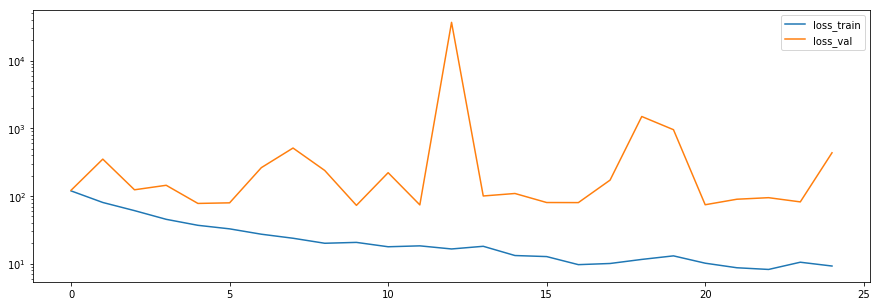

In [51]:
%matplotlib inline
fig, ax = plt.subplots(1,1)
fig.set_size_inches(15,5)
for part in losses.keys():
    ax.plot(losses[part],label='loss_'+part)
    ax.legend()
    ax.set_yscale('log')

We see a lot of overfitting after Epoch 9...

In [52]:
#save our model
#this enables us to reuse the trained model later-on using torch.load()
torch.save(best_model, 'fuel-prediction-prediction.torch')

/home/bewo/anaconda3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type FeedForwardNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
